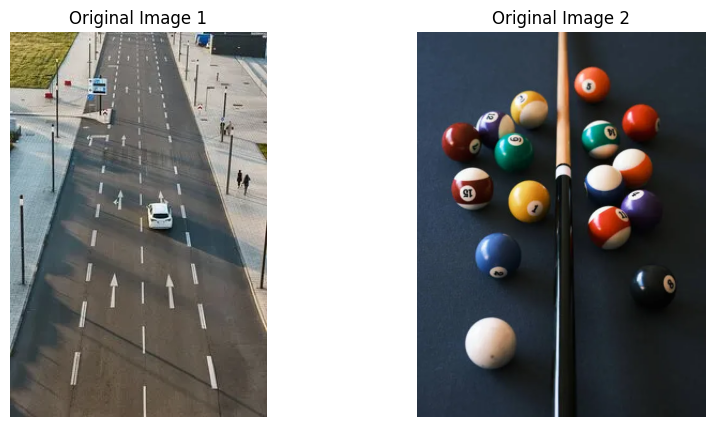

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image1 = cv2.imread("Lanes.png")  # Road lanes
image2 = cv2.imread("pool.png")   # Pool table

gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.title("Original Image 1")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
plt.title("Original Image 2")
plt.axis("off")

plt.show()


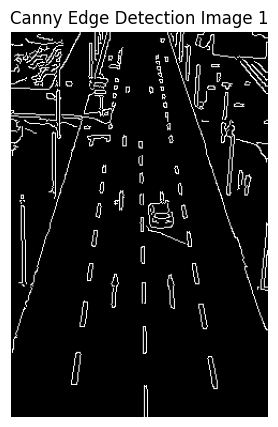

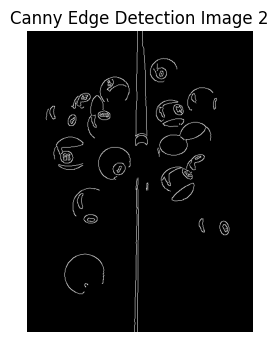

In [2]:
blurred1 = cv2.GaussianBlur(gray1, (5, 5), 0)
blurred2 = cv2.GaussianBlur(gray2, (5, 5), 0)

edges1 = cv2.Canny(blurred1, 50, 150, apertureSize=3)
edges2 = cv2.Canny(blurred2, 50, 150, apertureSize=3)

plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.imshow(edges1, cmap="gray")
plt.title("Canny Edge Detection Image 1")
plt.axis("off")
plt.show()

plt.subplot(1,2,2)
plt.imshow(edges2, cmap="gray")
plt.title("Canny Edge Detection Image 2")
plt.axis("off")

plt.show()


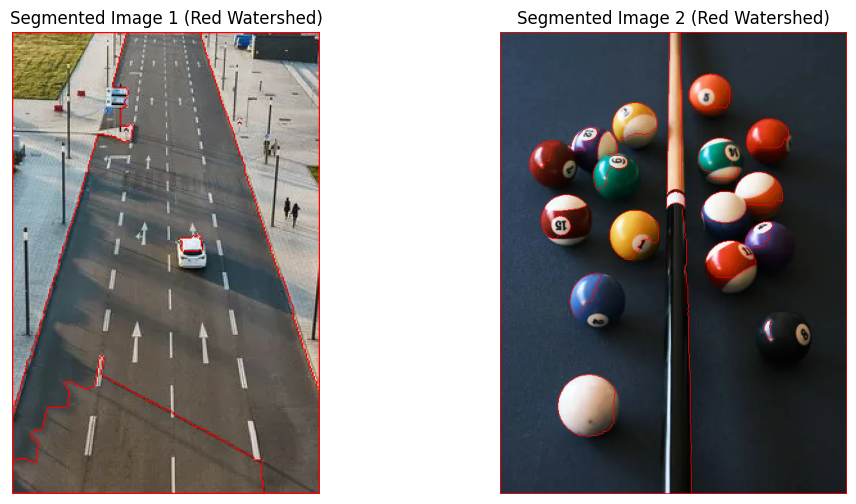

In [4]:
# Convert images to HSV color space and extract the Value channel
hsv1 = cv2.cvtColor(image1, cv2.COLOR_BGR2HSV)
hsv2 = cv2.cvtColor(image2, cv2.COLOR_BGR2HSV)
gray1 = hsv1[:, :, 2]  # Use the V channel as grayscale
gray2 = hsv2[:, :, 2]

# Function to apply watershed algorithm and highlight boundaries in red
def apply_watershed(image, gray):
    # Apply threshold
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Find sure foreground and background
    kernel = np.ones((3, 3), np.uint8)
    sure_bg = cv2.dilate(thresh, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    # Get unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Marker labeling
    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    # Apply Watershed
    image_copy = image.copy()
    cv2.watershed(image_copy, markers)
    
    # Highlight watershed boundaries in red
    image_copy[markers == -1] = [0, 0, 255]
    return image_copy

# Apply watershed on both images
segmented1 = apply_watershed(image1, gray1)
segmented2 = apply_watershed(image2, gray2)

# Display the results in Jupyter Notebook
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(cv2.cvtColor(segmented1, cv2.COLOR_BGR2RGB))
axes[0].set_title("Segmented Image 1 (Red Watershed)")
axes[0].axis("off")

axes[1].imshow(cv2.cvtColor(segmented2, cv2.COLOR_BGR2RGB))
axes[1].set_title("Segmented Image 2 (Red Watershed)")
axes[1].axis("off")

plt.show()


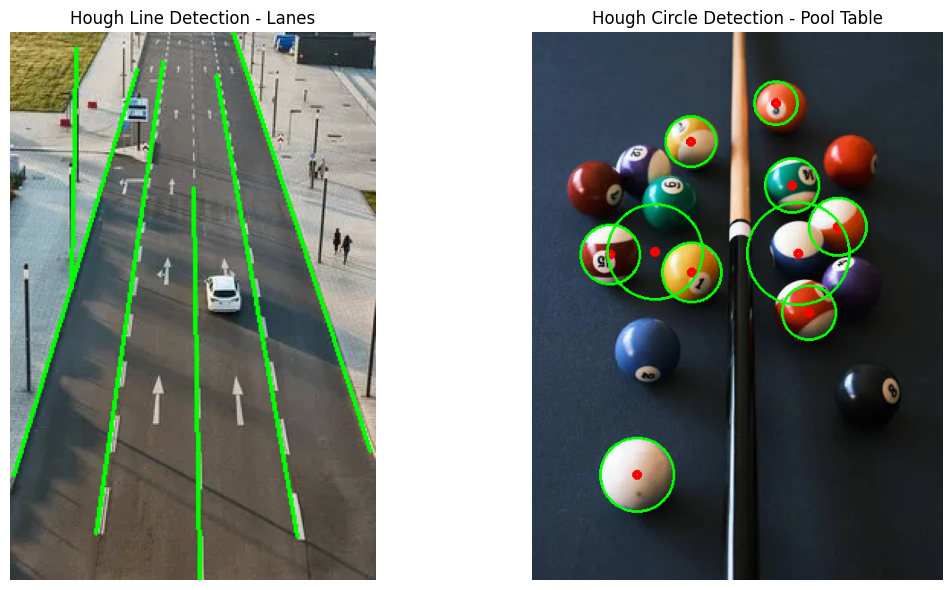

In [ ]:

# Function to detect and draw lines using Probabilistic Hough Transform
def detect_lines(image, edges):
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=50, maxLineGap=150)
    image_lines = image.copy()
    
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(image_lines, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green lines

    return image_lines

# Function to detect and draw circles using Hough Transform
def detect_circles(image, gray):
    image_circles = image.copy()
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=40, param1=50, param2=50, minRadius=20, maxRadius=80)
    
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            cv2.circle(image_circles, (i[0], i[1]), i[2], (0, 255, 0), 2)  # Green circle boundary
            cv2.circle(image_circles, (i[0], i[1]), 3, (0, 0, 255), 3)    # Red center dot

    return image_circles

# Apply Hough Transform
image1_lines = detect_lines(image1, edges1)
image2_circles = detect_circles(image2, gray2)

# Display results
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(cv2.cvtColor(image1_lines, cv2.COLOR_BGR2RGB))
axes[0].set_title("Hough Line Detection - Lanes")
axes[0].axis("off")

axes[1].imshow(cv2.cvtColor(image2_circles, cv2.COLOR_BGR2RGB))
axes[1].set_title("Hough Circle Detection - Pool Table")
axes[1].axis("off")

plt.tight_layout()
plt.show()


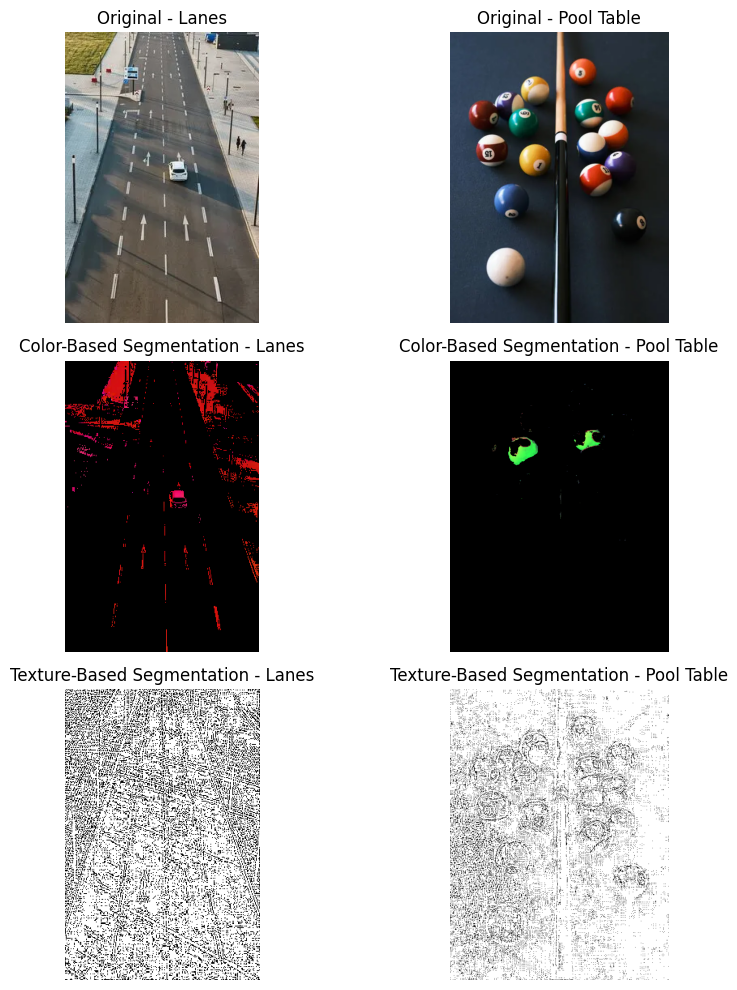

In [11]:
from skimage.filters import gabor
from skimage.feature import local_binary_pattern

# Load images
image_lanes = cv2.imread("Lanes.png")  # Update with correct filename
image_pool = cv2.imread("pool.png")

# Convert images to HSV color space
hsv_lanes = cv2.cvtColor(image_lanes, cv2.COLOR_BGR2HSV)
hsv_pool = cv2.cvtColor(image_pool, cv2.COLOR_BGR2HSV)

# ----- 🎨 Color-Based Segmentation -----
def color_segmentation(image, lower_range, upper_range):
    mask = cv2.inRange(image, lower_range, upper_range)
    segmented = cv2.bitwise_and(image, image, mask=mask)
    return segmented, mask

# Define color ranges (adjust as needed)
lower_white = np.array([0, 0, 200])   # Lighter colors (white lanes)
upper_white = np.array([180, 50, 255])

lower_green = np.array([35, 40, 40])  # Green-colored objects (pool table)
upper_green = np.array([85, 255, 255])

# Apply segmentation
lanes_color_seg, lanes_mask = color_segmentation(hsv_lanes, lower_white, upper_white)
pool_color_seg, pool_mask = color_segmentation(hsv_pool, lower_green, upper_green)

# ----- 🎭 Texture-Based Segmentation -----
def texture_segmentation(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Gabor filter (for texture)
    gabor_filtered, _ = gabor(gray, frequency=0.6)
    
    # Apply Local Binary Patterns (LBP)
    lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")
    
    # Normalize results
    gabor_norm = cv2.normalize(gabor_filtered, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    lbp_norm = cv2.normalize(lbp, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    # Combine both methods
    texture_combined = cv2.addWeighted(gabor_norm, 0.5, lbp_norm, 0.5, 0)
    
    _, texture_mask = cv2.threshold(texture_combined, 50, 255, cv2.THRESH_BINARY)
    
    return texture_combined, texture_mask

# Apply texture-based segmentation
lanes_texture_seg, lanes_texture_mask = texture_segmentation(image_lanes)
pool_texture_seg, pool_texture_mask = texture_segmentation(image_pool)

# ----- 🖼️ Visualizing Results -----
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

# Lanes
axes[0, 0].imshow(cv2.cvtColor(image_lanes, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title("Original - Lanes")

axes[0, 1].imshow(cv2.cvtColor(image_pool, cv2.COLOR_BGR2RGB))
axes[0, 1].set_title("Original - Pool Table")

axes[1, 0].imshow(cv2.cvtColor(lanes_color_seg, cv2.COLOR_BGR2RGB))
axes[1, 0].set_title("Color-Based Segmentation - Lanes")

axes[1, 1].imshow(cv2.cvtColor(pool_color_seg, cv2.COLOR_BGR2RGB))
axes[1, 1].set_title("Color-Based Segmentation - Pool Table")

axes[2, 0].imshow(lanes_texture_mask, cmap="gray")
axes[2, 0].set_title("Texture-Based Segmentation - Lanes")

axes[2, 1].imshow(pool_texture_mask, cmap="gray")
axes[2, 1].set_title("Texture-Based Segmentation - Pool Table")

# Hide axes and show
for ax in axes.ravel():
    ax.axis("off")

plt.tight_layout()
plt.show()


C:\Users\Tapassya Chaudhary\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.0755 - loss: 4.1437 - val_accuracy: 0.2086 - val_loss: 3.3228
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.2410 - loss: 3.1311 - val_accuracy: 0.2876 - val_loss: 2.9258
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.3115 - loss: 2.7724 - val_accuracy: 0.3226 - val_loss: 2.7668
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.3580 - loss: 2.5430 - val_accuracy: 0.3300 - val_loss: 2.6934
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.3927 - loss: 2.3785 - val_accuracy: 0.3506 - val_loss: 2.6112
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.4188 - loss: 2.2569 - val_accuracy: 0.3569 - val_loss: 2.5606
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.4455 - loss: 2.1484 - val_accuracy: 0.3628 - val_loss: 2.5571
Epoch 8/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.4666 - loss: 2.0374 - val_accu

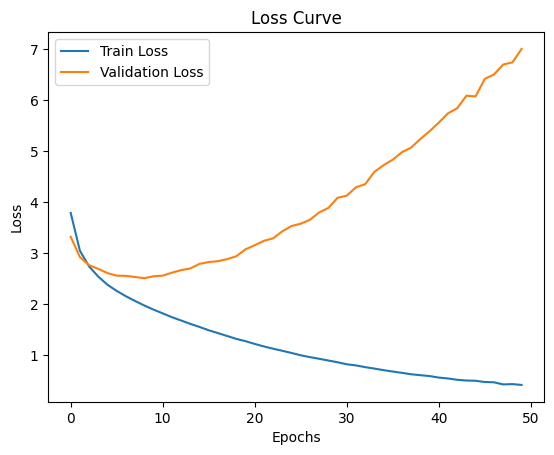

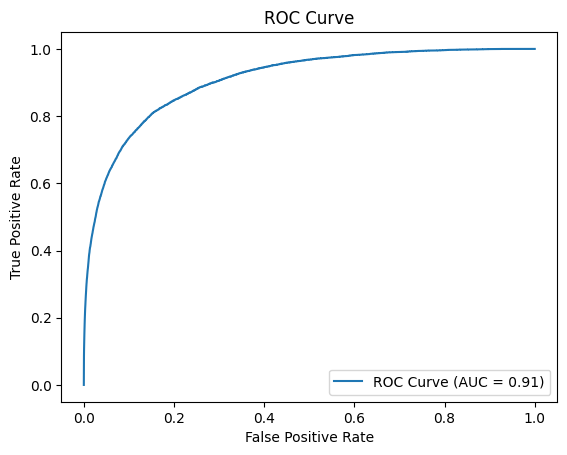

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


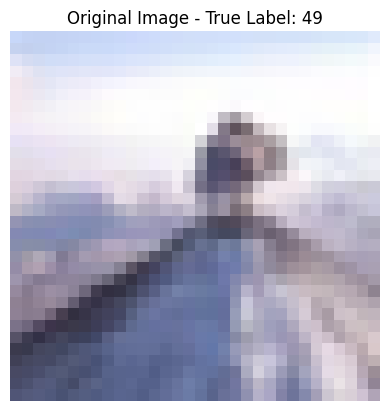

Predicted Label: 49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


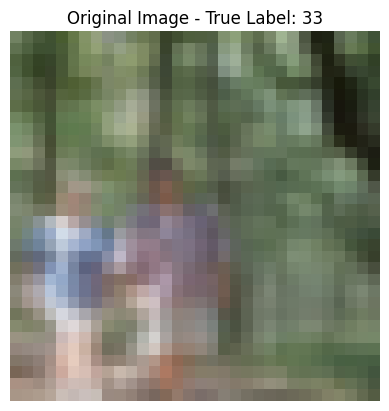

Predicted Label: 97


In [12]:
from sklearn.metrics import classification_report, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical

# Load CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

# Normalize images to [0,1]
x_train, x_test = x_train / 255.0, x_test / 255.0

# One-hot encode labels for 100 classes
num_classes = 100
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# CNN Model for CIFAR-100
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation="relu"),
    Dense(num_classes, activation="softmax")  # Now set to 100 classes
])

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(x_train, y_train, epochs=50, batch_size=64, validation_data=(x_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")

# Predict on test set
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate Classification Report
report = classification_report(y_true, y_pred, output_dict=True)
precision = np.mean([report[str(i)]['precision'] for i in range(num_classes)])
recall = np.mean([report[str(i)]['recall'] for i in range(num_classes)])
f1_score = np.mean([report[str(i)]['f1-score'] for i in range(num_classes)])

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")

# Plot Loss Curve
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred_probs.ravel())
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Test on Image 1 and Image 2
def predict_and_show(image_index):
    test_image = np.expand_dims(x_test[image_index], axis=0)  # Select image
    prediction = model.predict(test_image)
    predicted_label = np.argmax(prediction)

    # Display Original Image
    plt.imshow(x_test[image_index])
    plt.title(f"Original Image - True Label: {y_true[image_index]}")
    plt.axis("off")
    plt.show()

    print(f"Predicted Label: {predicted_label}")

# Show predictions for two test images
predict_and_show(0)
predict_and_show(1)



image 1/1 c:\Tapassya\Skills\University\LAB\Sem 6\Advance Computer Vision\Lab 6\temp1.png: 640x448 4 persons, 2 cars, 1 truck, 57.8ms
Speed: 3.1ms preprocess, 57.8ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 448)

📌 Objects detected in temp1.png:
🔹 person: 0.52
🔹 person: 0.47
🔹 person: 0.36
🔹 car: 0.33
🔹 truck: 0.31
🔹 car: 0.31
🔹 person: 0.26


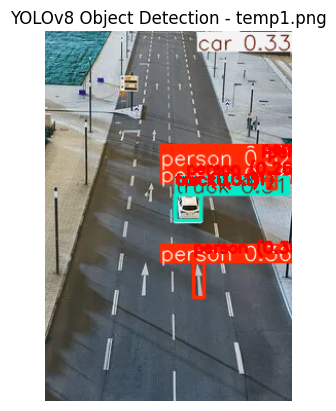


image 1/1 c:\Tapassya\Skills\University\LAB\Sem 6\Advance Computer Vision\Lab 6\temp2.png: 640x480 8 sports balls, 45.8ms
Speed: 4.4ms preprocess, 45.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

📌 Objects detected in temp2.png:
🔹 sports ball: 0.51
🔹 sports ball: 0.47
🔹 sports ball: 0.45
🔹 sports ball: 0.44
🔹 sports ball: 0.42
🔹 sports ball: 0.32
🔹 sports ball: 0.31
🔹 sports ball: 0.30


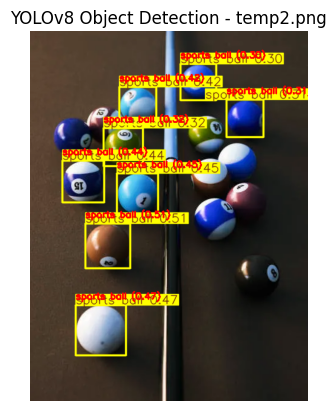

In [15]:
from ultralytics import YOLO
import os

# Load YOLOv8 model
model = YOLO("yolov8n.pt")

# Function to process and display detection results
def detect_and_show(image, temp_filename="temp_image.jpg"):
    # Ensure the image is read correctly
    if image is None:
        print("❌ Error: Image is not loaded properly.")
        return

    # Save image temporarily (YOLOv8 requires file input)
    cv2.imwrite(temp_filename, image)

    # Run YOLOv8 inference using the saved image path
    results = model.predict(temp_filename, save=False, verbose=True)

    # Extract detection results
    for r in results:
        image_with_boxes = r.plot()
        
        # Print detected objects and their probabilities
        print(f"\n📌 Objects detected in {temp_filename}:")
        for box in r.boxes.data:
            x1, y1, x2, y2, confidence, class_id = box.tolist()
            class_name = model.names[int(class_id)]  # Get object class name
            print(f"🔹 {class_name}: {confidence:.2f}")

            # Draw the label on the image
            label = f"{class_name} ({confidence:.2f})"
            cv2.putText(image_with_boxes, label, (int(x1), int(y1) - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Show the output image with detections
    plt.imshow(image_with_boxes)
    plt.title(f"YOLOv8 Object Detection - {temp_filename}")
    plt.axis("off")
    plt.show()

    # Delete temporary file after processing
    os.remove(temp_filename)

# Load Images
image1 = cv2.imread("Lanes.png")  # Ensure correct path
image2 = cv2.imread("pool.png")   # Ensure correct path

# Ensure images are loaded correctly before processing
if image1 is None or image2 is None:
    print("❌ Error: Could not load one or both images. Check file paths.")
else:
    detect_and_show(image1, "temp1.png")
    detect_and_show(image2, "temp2.png")



📌 Objects detected in Lanes.png:
🔹 Class 1: 1.00
🔹 Class 1: 0.99
🔹 Class 8: 0.93
🔹 Class 1: 0.76
🔹 Class 3: 0.71
🔹 Class 62: 0.62


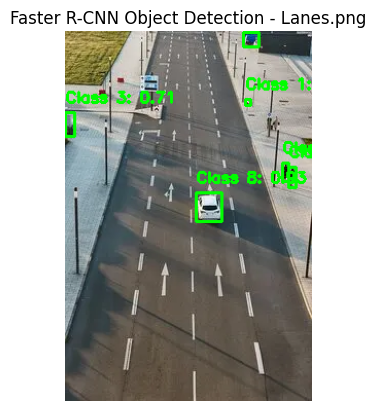


📌 Objects detected in Pool.png:
🔹 Class 37: 0.99
🔹 Class 37: 0.99
🔹 Class 37: 0.98
🔹 Class 37: 0.97
🔹 Class 37: 0.88
🔹 Class 55: 0.84
🔹 Class 37: 0.82
🔹 Class 37: 0.72
🔹 Class 55: 0.70
🔹 Class 74: 0.69


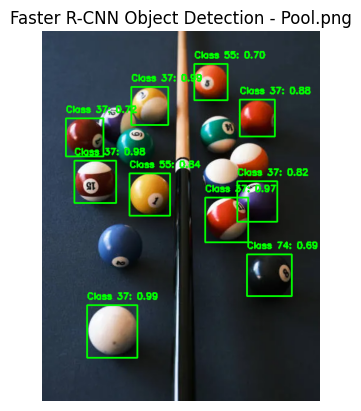

In [16]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import requests

# Load Faster R-CNN Model Pretrained on COCO Dataset
model_frcnn = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model_frcnn.eval()

# **Download COCO labels dynamically**
coco_labels_url = "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_labels.txt"
coco_labels = requests.get(coco_labels_url).text.strip().split("\n")

# Function for object detection and visualization
def detect_and_show(image_path, confidence_threshold=0.6):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([transforms.ToTensor()])
    image_tensor = transform(image).unsqueeze(0)  # Convert to batch format

    # Perform object detection
    with torch.no_grad():
        predictions = model_frcnn(image_tensor)

    # Draw bounding boxes on the image
    image_cv = cv2.imread(image_path)

    print(f"\n📌 Objects detected in {image_path}:")
    
    for i, box in enumerate(predictions[0]["boxes"]):
        score = predictions[0]["scores"][i].item()
        if score > confidence_threshold:  # Confidence threshold
            x1, y1, x2, y2 = map(int, box)
            class_id = int(predictions[0]["labels"][i].item())  # Get class ID

            # Get class name from downloaded COCO labels
            class_name = coco_labels[class_id] if class_id < len(coco_labels) else f"Class {class_id}"

            # Draw bounding box
            cv2.rectangle(image_cv, (x1, y1), (x2, y2), (0, 255, 0), 2)
            label = f"{class_name}: {score:.2f}"
            print(f"🔹 {label}")

            # Put label on image
            cv2.putText(image_cv, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Display the result
    plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
    plt.title(f"Faster R-CNN Object Detection - {image_path}")
    plt.axis("off")
    plt.show()

# Run detection on both images
detect_and_show("Lanes.png")  # Change to actual path if needed
detect_and_show("Pool.png")   # Change to actual path if needed
